# Methodology

The aim of investigating the mean-squared displacements is to fit a straight line to them as a function of timestep and therefore obtain the diffusion coefficient. 
This might seem like a straight forward concept, however, how one fits a straight line depends **heavily** on the nature of the data that is being investigated. 
The figure below introduces the different levels of detail required to fit a straight line, which we will work through in detail building up the complexity as we go. 

```{figure} _static/schematic_kinisi.pdf
---
alt: A schematic showing the different possibilities for the analysis of diffusion processes by mean-squared displacement.
width: 750px
---
A schematic of the process of diffusion coefficient determination, where the process used in `kinisi` is identified with the pink box.
```

## Finding the mean-squared displacement

Consider first the displacements that we calculate from an atomic simulation. 
We have performed a simulation of lithium lanthanum zirconium oxide (LLZO) to use as an example, we will consider initially the displacements, $\mathbf{x}$, that occur in 2.1 ps of simulation time. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from sklearn.utils import resample
from emcee import EnsembleSampler
from corner import corner

In [2]:
displacements = np.load('_static/displacements.npz')['disp']

print('Displacements shape', displacements.shape)

Displacements shape (192, 119, 3)


We can see that for this timestep, the `displacements` array has a shape of `(192, 119, 3)` this means that there are 192 atoms, each observed 119 times (i.e. in the whole simulation there 119 times that 2.1 ps of simulation is present), for 3 dimensions. 
Let us now visualise the probability distribution for the displacements. 

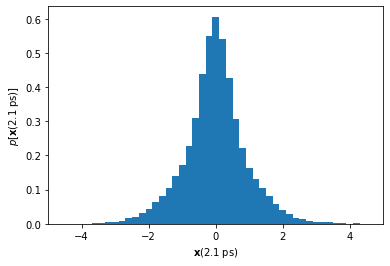

In [3]:
plt.hist(displacements.flatten(), bins=50, density=True)
plt.xlabel('$\mathbf{x}(2.1\;\mathrm{ps})$')
plt.ylabel('$p[\mathbf{x}(2.1\;\mathrm{ps})]$')
plt.xlim(-5, 5)
plt.show()

The ordinate axis in the fitting of the Einstein equation is the mean of the squared displacements, $\mathbf{r}^2$, therefore it is necessary that we square these displacements and determine the total displacement over all dimensions. 

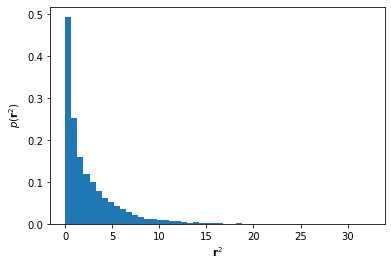

In [4]:
sq_displacements = np.sum(displacements ** 2, axis=2).flatten()

plt.hist(sq_displacements, bins=50, density=True)
plt.xlabel('$\mathbf{r}^2$')
plt.ylabel('$p(\mathbf{r}^2)$')
plt.show()

The mean of these squared displacements, $\langle\mathbf{r}^2\rangle$, can be found as the numerical mean.
Below, the mean is shown as a black vertical line over the histogram of the squared displacements. 

MSD = 2.554


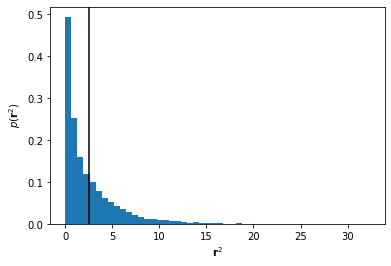

In [5]:
msd = np.mean(sq_displacements)

print(f'MSD = {msd:.3f}')

plt.hist(sq_displacements, bins=50, density=True)
plt.axvline(msd, color='k')
plt.xlabel('$\mathbf{r}^2$')
plt.ylabel('$p(\mathbf{r}^2)$')
plt.show()

Therefore, if we perform this operation at a series of different timesteps (the *x*-axis in the diffusion relation), we can populate the *y*-axis of our dataset. 
This is shown for the LLZO material below (note that throughout this description we focus on data in the diffusive regime alone). 

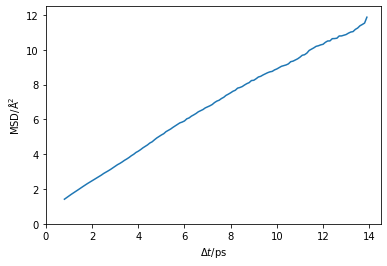

In [6]:
dt, msd = np.loadtxt('_static/msd.txt')

plt.plot(dt, msd)
plt.ylabel('MSD/Å$^2$')
plt.xlabel('$\Delta t$/ps')
plt.xlim(0, 14.5)
plt.ylim(0, 12.5)
plt.show()

The first thing we notice is that this data has no uncertainty associated with it. 
This seems unlikely given that if we run two different simulations, we will probably get different MSD plots. 

## Finding the uncertainty in the mean-squared displacement

It is possible to use [bootstrap mean resampling](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) to determine the distribution of the mean-squared displacement. 
If the distribution we are resampling is an accurate description of the true distribution, then this process is analogous to performing multiple observations of some subset of the true distribution. 
However, in order to accurately determine the distribution of mean-squared displacement, then we must resample *only* independent trajectories.


```{admonition} Thought experiment
Consider a particle traveling on a one-dimensional random walk for 9 steps, the trajectory that describes the displacement between the initial and 5th positions will be highly correlated with that between the 2nd and 6th positions, given that 4 of these steps are identical.
However, the trajectory between the 5th and final positions will be completely independent as there is no identical steps.
```

Given that the total LLZO simulation is only around 14 ps, it is not posssible for there to be 119 non-overlapping trajectories of 2.1 ps (2.1 ps × 119 = 249.9 ps, must more than our simulation), therefore some of the observations must be overlapping. 
The work of [Smith & Gillan](ftp://ftp.daresbury.ac.uk/ccp5.newsletter/45/ps/smith.ps.gz) outline an equation to determine the maximum number of independent trajectories, $N_i(\Delta t)$, as a function of timestep, 

```{math}
:label: ind
N_i(\Delta t) =  N_{\mathrm{atoms}}(\Delta t)\left\lfloor\frac{N_{\mathrm{obs}}(0)}{N_{\mathrm{obs}}(0) - N_{\mathrm{obs}}(\Delta t) + 1}\right\rfloor,
```

where $N_{\mathrm{obs}}(\Delta t)$ is the maximum number of displacement observations per atom and $N_{\mathrm{atoms}}(\Delta t)$ is the number of atoms, at a given timestep, $\Delta t$.
We can determine the this for the displacements above, by obtaining also the shape of the displacements array at the shortest timestep.  

In [7]:
displacements0 = np.load('_static/displacements.npz')['disp0']

N_i = displacements.shape[0] * int(
    displacements0.shape[1] / (displacements0.shape[1] - displacements.shape[1] + 1))
print('Maximum number of independent trajectories', N_i)

Maximum number of independent trajectories 1152


Therefore, when we perform the bootstrap mean resampling, with each iteration we should draw only 1152 samples from the distribution of the squared displacements. 

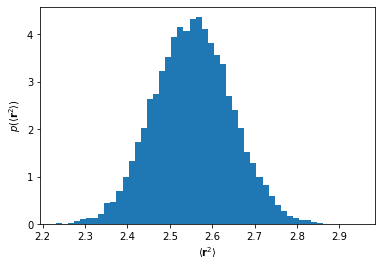

In [8]:
def mean_resample(samples: np.ndarray, n: int) -> np.ndarray:
    """
    Perform the bootstrap mean resampling for 10000 iterations.
    
    :param samples: Distribution to resample.
    :param n: Number of samples to draw each iteration. 
    :return: Distribution of mean. 
    """
    return np.array([np.mean(resample(samples, n_samples=n)) for j in range(10000)])

resampled_msd = mean_resample(sq_displacements, N_i)

plt.hist(resampled_msd, bins=50, density=True)
plt.xlabel(r'$\langle\mathbf{r}^2\rangle$')
plt.ylabel(r'$p(\langle\mathbf{r}^2\rangle)$')
plt.show()

It is clear now that, from this boostrap mean resampling, we have a distribution mean-squared displacements (which are normally distributed). 
From this, we can find the mean and standard deviation. 

In [9]:
print(f'MSD = {resampled_msd.mean():.3f}+\-{resampled_msd.std():.3f}')

MSD = 2.554+\-0.092


The value of the MSD is very similar (within sampling error) to that determined as the numerical mean of the squared displacements. 
However, now we have information about the distribution of the mean-squared displacement and we can visualise this for a real material below. 

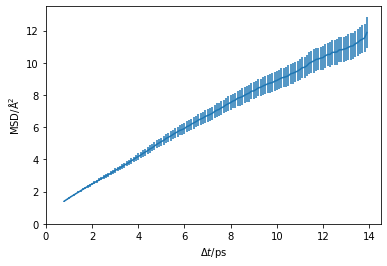

In [10]:
dt, msd, msd_std = np.loadtxt('_static/msd_std.txt')

plt.errorbar(dt, msd, msd_std)
plt.ylabel('MSD/Å$^2$')
plt.xlabel('$\Delta t$/ps')
plt.xlim(0, 14.5)
plt.ylim(0, 13.5)
plt.show()

## Understanding the correlation between measurements

The knowledge of the distribution of mean-squared displacements does not completely describe the variance in the data set.  

```{admonition} Thought experiment
Consider, a particle travelling on a one-dimensional random walk with a step size of 1 Å.
If, after 10 steps, the particle has been displaced by 5 Å then after 11 steps the particle could only be displaced by either 4 Å or 6 Å and after 12 steps the particle could only be displaced by 3, 4, 5, 6, 7 Å. 
```

This fact represents a high level of correlation between the distributions of mean-squared displacement at different timesteps. 
In order to quantify this correlation, we have derived an approach to <a href='./_static/derivation.pdf'>estimate the full covariance matrix</a> (a description of the correlation betwen the timesteps). 
The result of this derivation is that the covariance between two timesteps, $\mathrm{cov}_i\Big(\big\langle \mathbf{r}^2(\Delta t_n) \big\rangle, \big\langle \mathbf{r}^2(\Delta t_{n+m}) \big\rangle\Big)$, is the product of the variance at the first timestep, $\Delta t_n$ and the ratio of maximum independent trajectories at each timestep from Equation {eq}`ind`,

```{math}
:label: cov
\mathrm{cov}\Big(\big\langle \mathbf{r}^2(\Delta t_n) \big\rangle, \big\langle \mathbf{r}^2(\Delta t_{n+m}) \big\rangle\Big) = \sigma^2\big(\langle \mathbf{r}^2(\Delta t_n) \rangle\big) \frac{N_i(\Delta t_{n})}{N_i(\Delta t_{n+m})},
```

This approach is extremely computational efficient, as there is not additional calculation required to determine this estimate of the full covariance matrix. 
This is shown of our LLZO simulation in the figure below. 

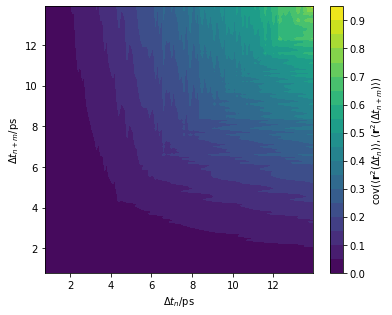

In [11]:
data = np.load('_static/cov.npz')
dt = data['dt']
cov = data['cov']

plt.subplots(figsize=(6, 4.9))
plt.contourf(*np.meshgrid(dt, dt), cov, levels=20)
plt.xlabel('$\Delta t_n$/ps')
plt.ylabel('$\Delta t_{n+m}$/ps')
plt.axis('equal')
plt.colorbar(label=r'$\mathrm{cov}' + 
             r'(\langle \mathbf{r}^2(\Delta t_n) \rangle, ' + 
             r'\langle \mathbf{r}^2(\Delta t_{n+m}) \rangle)$')
plt.show()

## Modelling a Gaussian process

The determination of the variance in the mean-squared displacement and estimation of the full covariance matrix allows the mean-squared displacement to be described as a covariant [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process), and therefore we can defined it with a `scipy.stats.multivariate_normal` object. 

In [12]:
gp = multivariate_normal(mean=msd, cov=cov, allow_singular=True)

This object, in theory, allows us to simulate potential trajectories that could be observed if our simulation were repeated. 
In the plot below, we compare such a simualation from the Gaussian process produced from the full covariance matrix with that produced when there only the diagonal terms are defined (i.e. only the variances for each mean-squared displacement). 

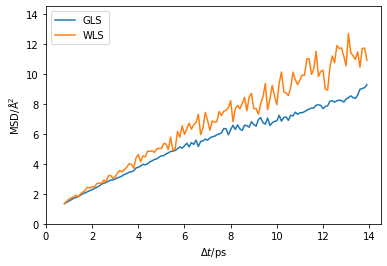

In [13]:
gp_wls = multivariate_normal(
    mean=msd, cov=np.diag(cov.diagonal()), allow_singular=True)

plt.plot(dt, gp.rvs(1).T, label='GLS')
plt.plot(dt, gp_wls.rvs(1).T, label='WLS')
plt.legend()
plt.ylabel('MSD/Å$^2$')
plt.xlabel('$\Delta t$/ps')
plt.xlim(0, 14.5)
plt.ylim(0, 14.5)
plt.show()

It is clear that the irratic changing in the mean-squared displacement that is observed in the plot with only the variances defined are unphysical when we consider the correlation thought experiment above. 

## Likelihood sampling a Gaussian process

As mentioned above, the aim of this process is to determine the diffusion coefficient and ordinate offset, and their model variance, by fitting the Einstein relation. 
In `kinisi`, we use Markov chain Monte Carlo (MCMC) posterior sampling to perform this, using the [`emcee` package](https://emcee.readthedocs.io).
To perform this, we define a `log_posterior` function, that imposes a Bayesian prior probability that the diffusion coefficent must be positive. 

In [14]:
def log_posterior(theta: np.ndarray) -> float:
    """
    Get the log likelihood for multivariate normal distribution.

    :param theta: Value of the gradient and intercept of the straight line.

    :return: Log-likelihood value.
    """
    if theta[0] < 0:
        return -np.inf
    model = dt * theta[0] + theta[1]
    logl = gp.logpdf(model)
    return logl

Then we can use a minimisation routine to determine maximum *a posteriori* values for the gradient and intercept. 

In [15]:
def nll(*args) -> float:
    """
    General purpose negative log-likelihood.

    :return: Negative log-likelihood
    """
    return -log_posterior(*args)

max_post = minimize(nll, [1, 0]).x

/Users/andrewmccluskey/mambaforge/envs/msd-errors/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [16]:
print(f'MAP: m = {max_post[0]:.3f}, c = {max_post[1]:.3f}')

MAP: m = 0.850, c = 0.745


After determining the maximum *a posteriori*, we can use `emcee` for sampling with 32 walkers for 1000 samples (with a 500 sample burn-in, which we discard in producing the `flatchain`). 

In [17]:
pos = max_post + max_post * 1e-3 * np.random.randn(32, max_post.size)

sampler = EnsembleSampler(*pos.shape, log_posterior)
sampler.run_mcmc(pos, 1000 + 500, progress=False)
flatchain = sampler.get_chain(flat=True, discard=500)

The diffusion coefficient (in units of cm<sup>2</sup>s<sup>-1</sup>) is found by dividing the gradient by 60000). 

In [18]:
flatchain[:, 0] /= 60000

We can then visualise these samples as a `corner` plot.

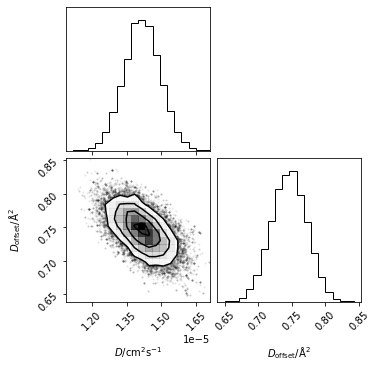

In [19]:
corner(flatchain, labels=['$D$/cm$^2$s$^{-1}$', '$D_{\mathrm{offset}}$/Å$^2$'])
plt.show()

It is also possible to visualise this as a traditional mean-squared displacement plot with a probability distribution of the Einstein relation values. 

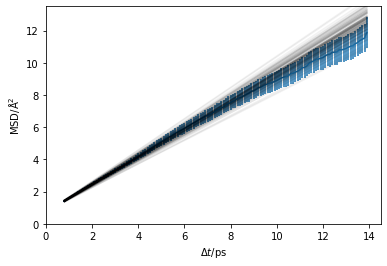

In [20]:
plt.errorbar(dt, msd, msd_std)
for i in np.random.randint(flatchain.shape[0], size=128):
    plt.plot(
        dt, flatchain[i, 0] * 60000 * dt + flatchain[i, 1], 
        color='k', alpha=0.05, zorder=10)
plt.ylabel('MSD/Å$^2$')
plt.xlabel('$\Delta t$/ps')
plt.xlim(0, 14.5)
plt.ylim(0, 13.5)
plt.show()